# <center>Secret Key Generation from Wireless Channel State Information (CSI)

This notebook demonstrates how Channel State Information (CSI) can be used 
for analyzing reciprocity in wireless channels and generating secret keys. 

## Step 1: Raw Reciprocity Analysis
Evaluate the reciprocity property of a wireless channel by computing Pearson correlation 
between an access point (AP) and a station (STA) across varying time lags.

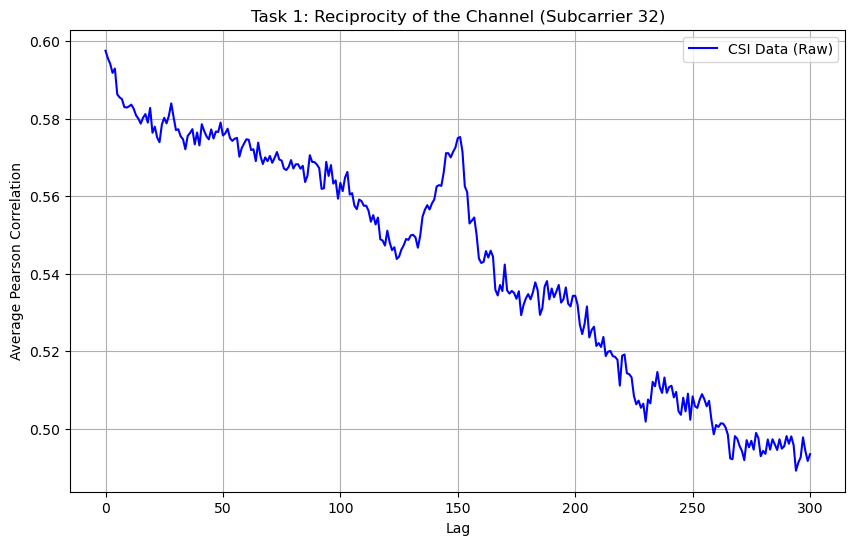

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ap_file = "ap.LoS_ShortRange_1_amplitudes_phases.csv"
sta_file = "sta.LoS_ShortRange_1_amplitudes_phases.csv"

ap_df = pd.read_csv(ap_file, header=None)
sta_df = pd.read_csv(sta_file, header=None)

# Select Subcarrier N 
index = 31 # Modify channel
ap_channel = ap_df.iloc[:, index].values
sta_channel = sta_df.iloc[:, index].values

# Window size and lags
window_size = 2000
max_lag = 300
lags = np.arange(0, max_lag + 1)
avg_correlations = []

# Function to compute Pearson correlation
def pearson(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0  # Return zero correlation if no variation
    return np.corrcoef(x, y)[0, 1]

# Compute Pearson correlation for each lag efficiently
for lag in lags:
    ap_window = ap_channel[:len(ap_channel) - lag]
    sta_window = sta_channel[lag:]
    correlation = pearson(ap_window, sta_window)
    avg_correlations.append(correlation)

# Plot the averaged correlation vs. lag
plt.figure(figsize=(10, 6))
plt.plot(lags, avg_correlations, label="CSI Data (Raw)", color="blue")
plt.xlabel("Lag")
plt.ylabel("Average Pearson Correlation")
plt.title(f"Task 1: Reciprocity of the Channel (Subcarrier {index+1})")
plt.legend()
plt.grid()
plt.show()


## Step 2: Filtering and Enhanced Reciprocity
Apply Savitzky-Golay filtering to smooth CSI data before correlation analysis, 
reducing noise and highlighting reciprocity.

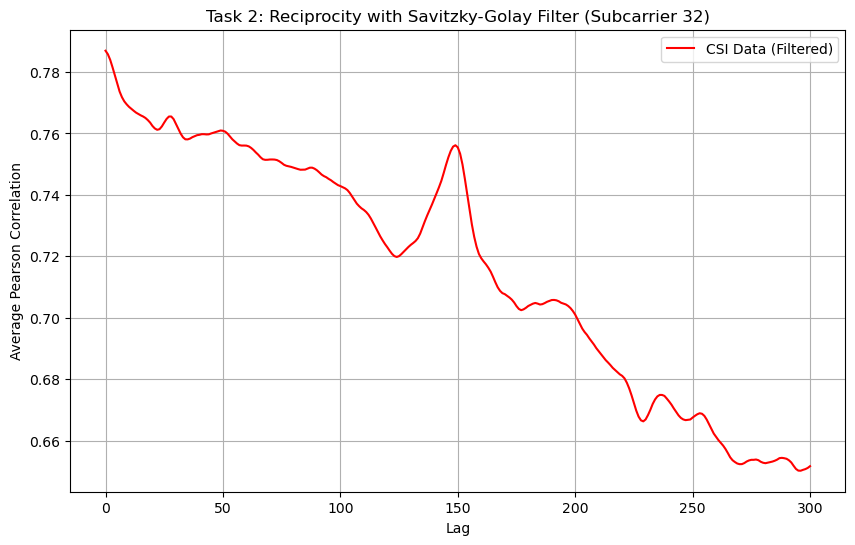

Comparison with Task 1:
- Golay filtering smooths the data, reducing noise and high-frequency variations.
- This should generally increase the correlation at lower lags, improving channel reciprocity.
- If the filtered correlation values are significantly higher than raw data, it indicates effective smoothing.
- However, excessive filtering may remove useful variations, so optimal parameters are important.


In [46]:
# Task 2: Apply Savitzky-Golay Filtering and Compute Correlation

from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 11  # Odd No.
poly_order = 2  # Polynomial order for smoothing
ap_filtered = savgol_filter(ap_channel, window_length, poly_order)
sta_filtered = savgol_filter(sta_channel, window_length, poly_order)

# Compute Pearson correlation for filtered data
avg_correlations_filtered = []
for lag in lags:
    ap_window = ap_filtered[:len(ap_filtered) - lag]
    sta_window = sta_filtered[lag:]
    correlation = pearson(ap_window, sta_window)
    avg_correlations_filtered.append(correlation)

# Plot the averaged correlation vs. lag
plt.figure(figsize=(10, 6))
plt.plot(lags, avg_correlations_filtered, label="CSI Data (Filtered)", color="red")
plt.xlabel("Lag")
plt.ylabel("Average Pearson Correlation")
plt.title(f"Task 2: Reciprocity with Savitzky-Golay Filter (Subcarrier {index+1})")
plt.legend()
plt.grid()
plt.show()

# Analysis of Golay Filtering Impact
print("Comparison with Task 1:")
print("- Golay filtering smooths the data, reducing noise and high-frequency variations.")
print("- This should generally increase the correlation at lower lags, improving channel reciprocity.")
print("- If the filtered correlation values are significantly higher than raw data, it indicates effective smoothing.")
print("- However, excessive filtering may remove useful variations, so optimal parameters are important.")


## Step 3: Secret Key Generation
Implement a 4-level quantization scheme on filtered CSI data, generate 100-bit 
keys, and evaluate agreement between AP and STA keys with a 10% error threshold.  
Compute the **Key Generation Rate (KGR)** and analyze key similarity distribution.

Total Keys Generated: 200
Successful Keys (Agreement within 10% error): 91
Key Generation Rate (KGR): 45.50%


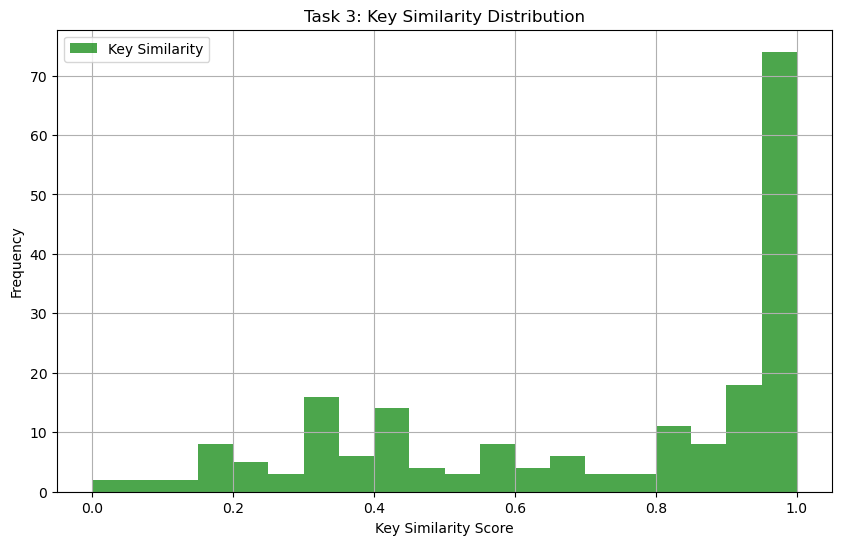

In [48]:
# Task 3: Secret Key Generation Using 4-Level Quantization

def quantize(data, levels=4):
    """Quantize data into discrete levels."""
    min_val, max_val = np.min(data), np.max(data)
    if max_val == min_val:
        return np.zeros_like(data, dtype=int)  # Handle zero-variance case
    step = (max_val - min_val) / levels
    quantized = np.floor((data - min_val) / step).astype(int)
    return np.clip(quantized, 0, levels - 1)

# Quantize the filtered CSI data
ap_quantized = quantize(ap_filtered)
sta_quantized = quantize(sta_filtered)

# Split quantized values into 100-bit keys
key_length = 100
num_keys = ap_quantized.size // key_length
keys_ap = ap_quantized[:num_keys * key_length].reshape((num_keys, key_length))
keys_sta = sta_quantized[:num_keys * key_length].reshape((num_keys, key_length))

# Key agreement check with 10% error threshold
def key_agreement(key1, key2, threshold=0.1):
    mismatches = np.sum(key1 != key2)
    return mismatches / len(key1) < threshold

successful_keys = sum(key_agreement(keys_ap[i], keys_sta[i]) for i in range(num_keys))

# Compute Key Generation Rate (KGR)
kgr = successful_keys / num_keys if num_keys > 0 else 0

# Print additional details
print(f"Total Keys Generated: {num_keys}")
print(f"Successful Keys (Agreement within 10% error): {successful_keys}")
print(f"Key Generation Rate (KGR): {kgr * 100:.2f}%")

# Plot Key Similarity Distribution
key_similarity = [1 - (np.sum(keys_ap[i] != keys_sta[i]) / key_length) for i in range(num_keys)]
plt.figure(figsize=(10, 6))
plt.hist(key_similarity, bins=20, color='green', alpha=0.7, label='Key Similarity')
plt.xlabel("Key Similarity Score")
plt.ylabel("Frequency")
plt.title("Task 3: Key Similarity Distribution")
plt.legend()
plt.grid()
plt.show()